## Start SBI framework

In [2]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sbi.inference import SNPE
from sbi.utils import BoxUniform

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Harmonic Oscillator Simulator Implementation
### Define the simulator class

In [17]:
class HarmonicOscillator:
    def __init__(self, time_points=100, t_max=10.0):
        """Initialize oscillator with time parameters"""
        self.time = np.linspace(0, t_max, time_points)
        
    def simulate(self, params, noise_level=0.0, amplitude=1.0, phase=0.0, damping=0.0):
        """
        Simulate oscillator trajectories with configurable parameters
        
        Args:
            params: Tensor (n_simulations, 2) with mass and spring constant
            noise_level: Strength of additive Gaussian noise
            amplitude: Initial oscillation amplitude
            phase: Initial phase
            damping: Damping coefficient
        """
        m, k = params[:, 0], params[:, 1]
        omega = torch.sqrt(k / m)
        
        t = torch.tensor(self.time, dtype=torch.float32)
        trajectories = amplitude * torch.exp(-damping * t) * \
                      torch.sin(omega[:, None] * t + phase)
        
        if noise_level > 0:
            noise = noise_level * torch.randn_like(trajectories)
            trajectories += noise
            
        return trajectories

### Setup Prior and Inference Method 
### Define parameter ranges and initialize SBI framework

In [18]:
# Define parameter ranges
mass_range = (0.1, 10)
k_range = (10.0, 100.0)

# Setup prior distribution
prior = BoxUniform(
    low=torch.tensor([mass_range[0], k_range[0]]),
    high=torch.tensor([mass_range[1], k_range[1]])
)

# Initialize inference method
inference_method = SNPE(prior=prior)

### Generate Training Data
### Create simulated trajectories for training

In [19]:
from sklearn.model_selection import train_test_split

# Initialize simulator
simulator = HarmonicOscillator()

# Generate training data
n_simulations = 5000
noise_level = 0.01

# Sample parameters and simulate trajectories
theta_train = prior.sample((n_simulations,))
x_train = simulator.simulate(theta_train, noise_level=noise_level)


### Train Neural Density Estimator

In [24]:
# Import a neural network model for posterior estimation
# one can choose between Masked Autoregressive Flow (MAF) and Neural Spline Flow (NSF)
# or mdn (Mixture Density Networks)

# documentation: https://sbi-dev.github.io/sbi/latest/reference/models/#sbi.neural_nets.factory.posterior_nn

from sbi.utils.get_nn_models import posterior_nn

# Costruzione di un Masked Autoregressive Flow (MAF) personalizzato
# Construction of a custom Masked Autoregressive Flow (MAF)
density_estimator = posterior_nn(
    model='maf',                    # Use a 'maf' (Masked Autoregressive Flow) (other options: 'nsf', 'mdn')
    hidden_features=64,            # number of hidden nodes per layer
    num_transforms=5,               # number of layers of the flow
    activation_function="relu",     # Use ReLU as activation
    dropout_probability=0,        # Apply a dropout
    use_batch_norm=False             # Use batch normalization
)

# training
inference_method = SNPE(prior=prior, density_estimator=density_estimator)
density_estimator = inference_method.append_simulations(theta_train, x_train).train(
    validation_fraction=0.2,
    max_num_epochs=500,  
    stop_after_epochs=20,  
    learning_rate=1e-3,   
    training_batch_size=256       
)


# Build posterior distribution
posterior = inference_method.build_posterior(density_estimator)

/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_42184/607163170.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  density_estimator = posterior_nn(


 Neural network successfully converged after 147 epochs.

### Perform Inference on a Single Test Case

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]


Inference Results:
-----------------
True parameters: Mass = 6.126, k = 67.467
Posterior means: Mass = 6.107, k = 67.117
Posterior std: Mass = 1.592, k = 17.292


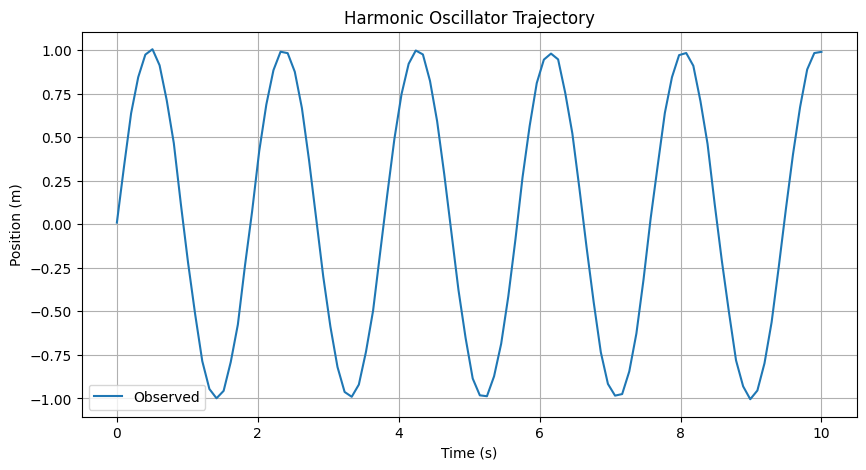

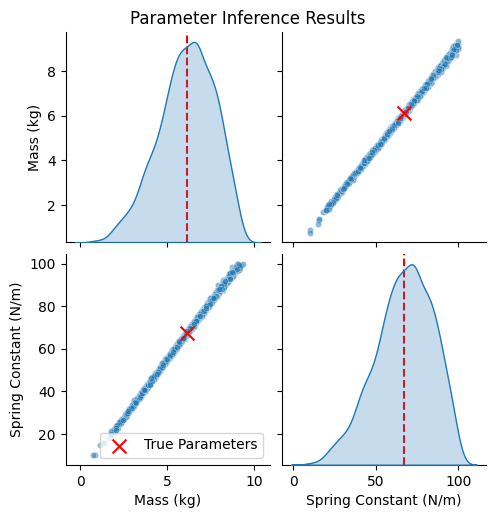

In [26]:
# Generate test parameters and data
test_params = prior.sample((1,))
observed_data = simulator.simulate(
    test_params,
    noise_level=noise_level,
    amplitude=1.0,
    phase=0.0,
    damping=0.0
)[0]  # Take first trajectory

"""
Perform Inference: Sample from posterior distribution
"""
# Sample from posterior
n_samples = 2000
posterior_samples = posterior.sample((n_samples,), x=observed_data)

# Create DataFrame for visualization
posterior_df = pd.DataFrame(
    posterior_samples.numpy(),
    columns=["Mass (kg)", "Spring Constant (N/m)"]
)

# Print results
print("\nInference Results:")
print("-----------------")
print(f"True parameters: Mass = {test_params[0,0]:.3f}, k = {test_params[0,1]:.3f}")
print(f"Posterior means: Mass = {posterior_samples.mean(dim=0)[0]:.3f}, k = {posterior_samples.mean(dim=0)[1]:.3f}")
print(f"Posterior std: Mass = {posterior_samples.std(dim=0)[0]:.3f}, k = {posterior_samples.std(dim=0)[1]:.3f}")

"""
Visualize Results - Trajectory Plot
"""
plt.figure(figsize=(10, 5))
plt.plot(simulator.time, observed_data.numpy(), label='Observed')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Harmonic Oscillator Trajectory')
plt.legend()
plt.grid(True)
plt.show()


"""
Visualize Results - Parameter Distributions
"""
# Create pairplot of posterior distributions
g = sns.pairplot(
    posterior_df,
    diag_kind="kde",
    plot_kws={"alpha": 0.5, "s": 20}  # ridotto size dei punti
)

# Add true values
true_params = test_params[0].numpy()
for i, ax in enumerate(np.diag(g.axes)):
    ax.axvline(true_params[i], color='red', linestyle='--')

# Add true values to scatter plot
g.axes[1, 0].scatter(
    true_params[0],
    true_params[1],
    color='red',
    marker='x',
    s=100,
    label='True Parameters'
)
g.axes[0, 1].scatter(
    true_params[1],
    true_params[0],
    color='red',
    marker='x',
    s=100,
    label='True Parameters'
)
g.axes[1, 0].legend()

plt.suptitle('Parameter Inference Results', y=1.02)
plt.show()


### Global Test Set Evaluation

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]


Global Performance on Test Set:
-------------------------------
Mean Absolute Error (Mass): 1.291
Mean Absolute Error (Spring Constant): 14.919


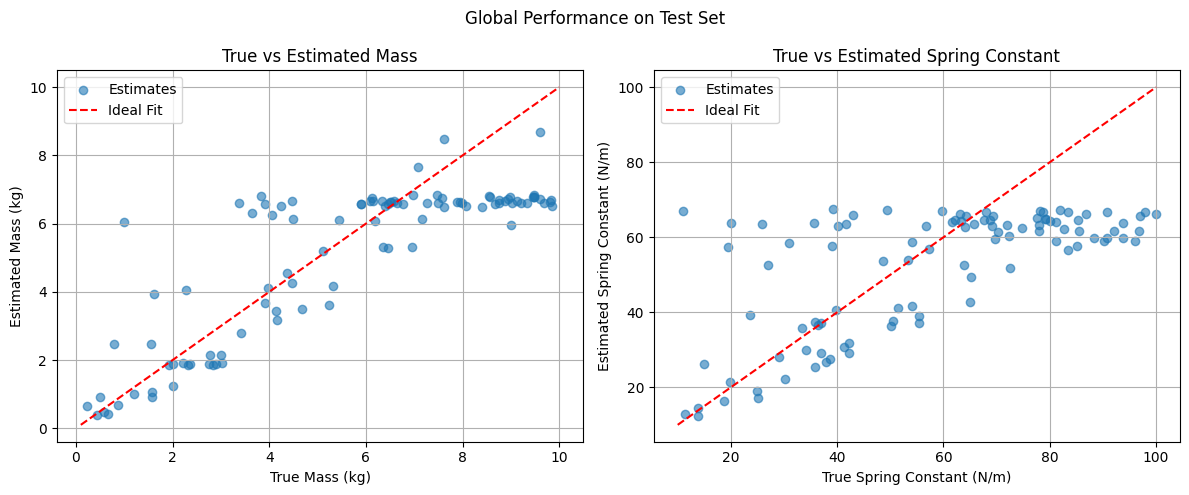

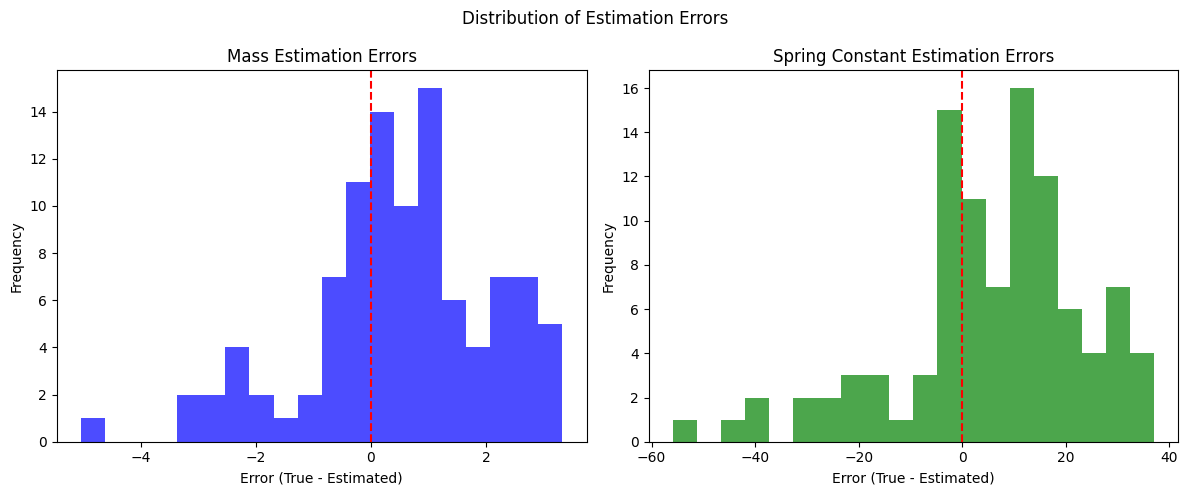

In [27]:

# Generate a larger test set
n_test_samples = 100  # You can adjust this value for larger test sets
theta_test = prior.sample((n_test_samples,))
x_test = simulator.simulate(theta_test, noise_level=noise_level)

# Perform inference for all test samples
posterior_means = []
posterior_stds = []
for i in range(n_test_samples):
    posterior_samples_test = posterior.sample((n_samples,), x=x_test[i])
    posterior_means.append(posterior_samples_test.mean(dim=0))
    posterior_stds.append(posterior_samples_test.std(dim=0))

# Convert lists to tensors
posterior_means = torch.stack(posterior_means)
posterior_stds = torch.stack(posterior_stds)

# Convert true values and predictions to numpy arrays for plotting
theta_test_np = theta_test.numpy()
posterior_means_np = posterior_means.numpy()

# Compute mean absolute error for each parameter
mae_mass = np.mean(np.abs(theta_test_np[:, 0] - posterior_means_np[:, 0]))
mae_k = np.mean(np.abs(theta_test_np[:, 1] - posterior_means_np[:, 1]))

print(f"\nGlobal Performance on Test Set:")
print(f"-------------------------------")
print(f"Mean Absolute Error (Mass): {mae_mass:.3f}")
print(f"Mean Absolute Error (Spring Constant): {mae_k:.3f}")


"""
Visualize Global Performance - Scatter Plot of True vs Estimated Parameters
"""

plt.figure(figsize=(12, 5))

# Mass parameter
plt.subplot(1, 2, 1)
plt.scatter(theta_test_np[:, 0], posterior_means_np[:, 0], alpha=0.6, label='Estimates')
plt.plot([mass_range[0], mass_range[1]], [mass_range[0], mass_range[1]], 'r--', label='Ideal Fit')
plt.xlabel('True Mass (kg)')
plt.ylabel('Estimated Mass (kg)')
plt.title('True vs Estimated Mass')
plt.legend()
plt.grid(True)

# Spring Constant parameter
plt.subplot(1, 2, 2)
plt.scatter(theta_test_np[:, 1], posterior_means_np[:, 1], alpha=0.6, label='Estimates')
plt.plot([k_range[0], k_range[1]], [k_range[0], k_range[1]], 'r--', label='Ideal Fit')
plt.xlabel('True Spring Constant (N/m)')
plt.ylabel('Estimated Spring Constant (N/m)')
plt.title('True vs Estimated Spring Constant')
plt.legend()
plt.grid(True)

plt.suptitle('Global Performance on Test Set')
plt.tight_layout()
plt.show()

"""
Visualize Global Performance - Distribution of Estimation Errors
"""

# Compute errors
mass_errors = theta_test_np[:, 0] - posterior_means_np[:, 0]
k_errors = theta_test_np[:, 1] - posterior_means_np[:, 1]

# Plot histograms of errors
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mass_errors, bins=20, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Mass Estimation Errors')
plt.xlabel('Error (True - Estimated)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(k_errors, bins=20, alpha=0.7, color='green')
plt.axvline(0, color='red', linestyle='--')
plt.title('Spring Constant Estimation Errors')
plt.xlabel('Error (True - Estimated)')
plt.ylabel('Frequency')

plt.suptitle('Distribution of Estimation Errors')
plt.tight_layout()
plt.show()
